# SLV Time Series

**Import all the relevant packages.** 

In [1]:
import pandas as pd
import datetime
import pickle
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [2]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

### Data Cleaning/Wrangling

**Read into variables data from the dataset.**

In [6]:
slv = pd.read_csv('data/SLV.csv')

**Review data to ensure proper implementation.**

In [7]:
slv.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-04-28,12.900,13.980,12.870,13.812,13.812,23432000
1,2006-05-01,13.920,14.179,13.750,13.870,13.870,14835000
2,2006-05-02,14.245,14.400,14.100,14.365,14.365,12511000
3,2006-05-03,14.450,14.464,13.413,13.925,13.925,15141000
4,2006-05-04,13.950,14.287,13.680,14.000,14.000,11075000


**Check that data conforms to expectations.**

In [8]:
slv.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3890.000000,3890.000000,3890.000000,3890.000000,3890.000000,3.890000e+03
mean,18.866024,19.036925,18.673275,18.859959,18.859959,1.391545e+07
std,6.560916,6.642149,6.456286,6.559651,6.559651,1.748706e+07
min,8.710000,9.050000,8.450000,8.850000,8.850000,1.039000e+06
25%,14.390000,14.510000,14.300000,14.400000,14.400000,5.673300e+06
50%,16.540001,16.660000,16.389999,16.540001,16.540001,8.682400e+06
75%,21.627499,21.850000,21.420000,21.637499,21.637499,1.573058e+07
max,47.619999,48.349998,46.549999,47.259998,47.259998,2.954000e+08


**Format date as *Datetime* and set date as index.**

In [7]:
fmt = '%Y-%m-%d' 
slv['Date']=pd.to_datetime(slv['Date'],format=fmt)
slv.set_index(pd.DatetimeIndex(slv['Date']),inplace=True)

**Check for null values.**

In [10]:
slv.isnull().values.any()

False

**Verify redundant column and remove it**

In [11]:
slv[slv['Close']!=slv['Adj Close']]

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,


**Add column representing trading day**

In [8]:
slv.drop(['Adj Close'],axis=1,inplace=True)
slv['Day'] = np.arange(1,len(slv)+1)
slv = slv[['Day','Open','Low','High','Close','Volume']]
slv.head()

,Day,Open,Low,High,Close,Volume
Date,,,,,,
2006-04-28,1,12.900,12.870,13.980,13.812,23432000
2006-05-01,2,13.920,13.750,14.179,13.870,14835000
2006-05-02,3,14.245,14.100,14.400,14.365,12511000
2006-05-03,4,14.450,13.413,14.464,13.925,15141000
2006-05-04,5,13.950,13.680,14.287,14.000,11075000


**Add column representing percent change**

In [13]:
slv['pct_change'] = 100*slv['Close'].pct_change()

In [14]:
path = 'data/slv_working.pkl'
with open(path, 'wb') as f:
    pickle.dump(slv,f)

### Exploratory Data Analysis

**Graph the data.**

In [15]:
slv.tail()

,Day,Open,Low,High,Close,Volume,pct_change
Date,,,,,,,
2021-10-04,3886,20.760000,20.700001,21.030001,20.980000,25183900,0.720115
2021-10-05,3887,20.840000,20.709999,20.980000,20.920000,21548900,-0.285987
2021-10-06,3888,20.750000,20.650000,21.010000,20.959999,22553300,0.191200
2021-10-07,3889,20.790001,20.780001,21.100000,20.900000,19484300,-0.286255
2021-10-08,3890,21.389999,20.940001,21.440001,20.950001,33290400,0.239239


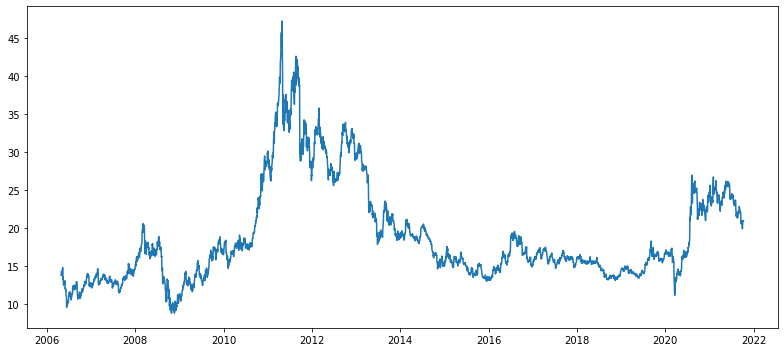

In [148]:
fig1, ax = plt.subplots(1,1,figsize=(11,5))
ax.plot(slv.index,slv['Close'])
fig1.tight_layout()
fig1.savefig('plots/fig1.png')

In [143]:
print(slv.index[np.where(slv['Close'] > 47.25)])

DatetimeIndex(['2011-04-28'], dtype='datetime64[ns]', name='Date', freq=None)


**Compare data with GLD (Gold) and SPY (Large Cap Index)**

In [17]:
# Read in comparison data
gld = pd.read_csv('data/GLD.csv')
spy = pd.read_csv('data/SPY.csv')
fmt = '%Y-%m-%d' 
gld['Date']=pd.to_datetime(gld['Date'],format=fmt)
gld.set_index(pd.DatetimeIndex(gld['Date']),inplace=True)
spy['Date']=pd.to_datetime(spy['Date'],format=fmt)
spy.set_index(pd.DatetimeIndex(spy['Date']),inplace=True)

# Calculate percent change from beginning of dataset
slv0 = slv.loc['2006-04-28','Close']
gld0 = gld.loc['2006-04-28','Close']
spy0 = spy.loc['2006-04-28','Close']
silver = (slv['Close'] - slv0)/slv0
gold = (gld['Close'] - gld0)/gld0
market = (spy['Close'] - spy0)/spy0

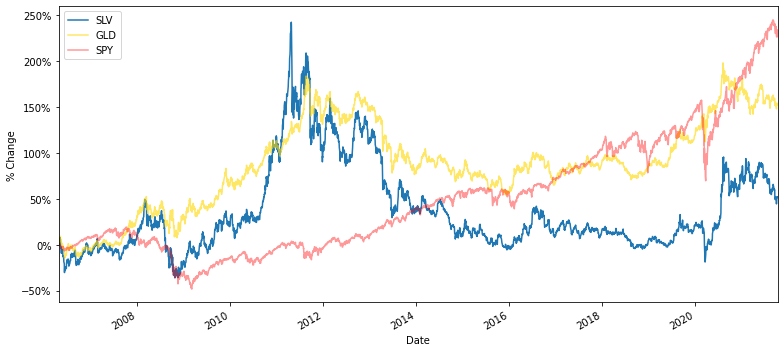

In [147]:
import matplotlib.ticker as tick
fig2, ax = plt.subplots(1,1,figsize=(11,5))
xmin, xmax = datetime.date(2006,4,28), datetime.date(2021,10,8)
silver.plot(label='SLV',xlim=[xmin,xmax])
gold.plot(color='gold',alpha=0.6,label='GLD',xlim=[xmin,xmax])
market.plot(color='red',alpha=0.4,label='SPY',xlim=[xmin,xmax])
ax.yaxis.set_major_formatter(tick.PercentFormatter(1,decimals=0))
ax.legend(loc='best')
ax.set_ylabel('% Change')
fig2.tight_layout()
fig2.savefig('plots/fig2.png',bbox_inches='tight')

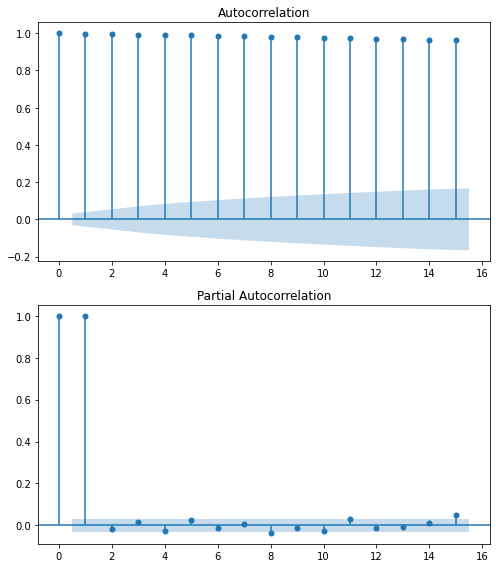

In [19]:
data = slv['Close']
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(7,8))
plot_acf(data,alpha=0.05,lags=15, ax=ax1)
plot_pacf(data,alpha=0.05,lags=15, ax=ax2)
fig.tight_layout()

**SLV exhibits very slight fall-off in autocorrelation on a daily basis. However, in the partial
autocorrelation plot (PACF), only lag 1 shows a significant correlation.**

**Test for stationarity**

In [20]:
from statsmodels.tsa.stattools import adfuller,kpss
adf_result = adfuller(slv['Close'])
print(f'Augmented Dickey-Fuller test p-value: {adf_result[1]}')

Augmented Dickey-Fuller test p-value: 0.2724331971404951


**SLV data is not stationary**

**But removing the trend and seasonal components does stationarize the data.**

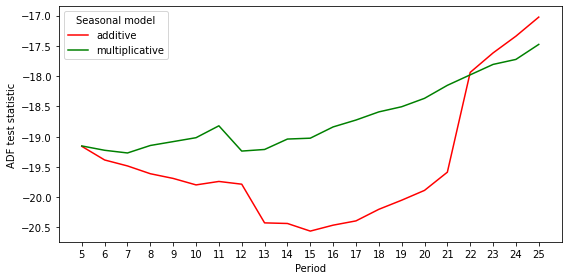

In [21]:
models = ['additive','multiplicative']
#periods=[5,21,252]
periods = np.arange(5,26)
adf = pd.DataFrame(columns=['additive','multiplicative'],index=periods)
for model in models:
    for period in periods:
        deco = sm.tsa.seasonal_decompose(slv['Close'],model=model,period=period)
        trend = deco.trend
        seasonal = deco.seasonal
        residual = deco.resid
        residual.dropna(inplace=True)
        adf.loc[period,model] = adfuller(residual)[0]
fig = plt.figure(figsize=(8,4))
adf.additive.plot(color='red',label='additive')
plt.xticks(periods)
plt.xlabel('Period')
plt.ylabel('ADF test statistic')
adf.multiplicative.plot(color='green',label='multiplicative')
plt.legend(title='Seasonal model')
fig.tight_layout()

Augmented Dickey-Fuller test results: (-20.559630164706263, 0.0)


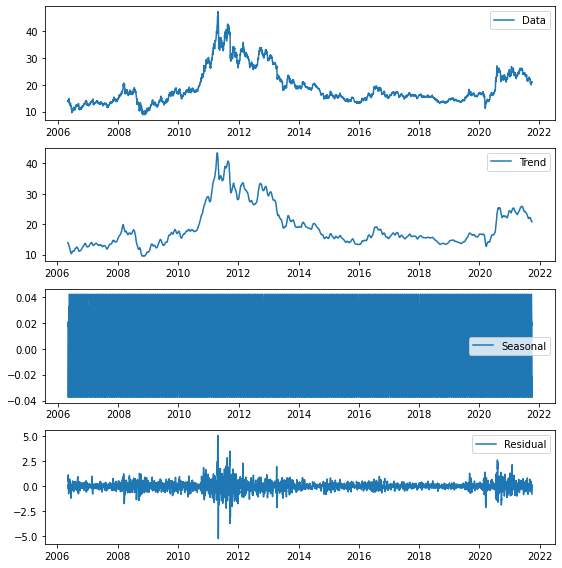

In [22]:
deco = sm.tsa.seasonal_decompose(slv['Close'],model='additive',period=15)
trend = deco.trend
seasonal = deco.seasonal
residual = deco.resid

fig = plt.figure(figsize=(8,8))
plt.subplot(411)
plt.plot(slv['Close'],label = 'Data')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal, label = 'Seasonal')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residual')
plt.legend(loc = 'best')
fig.tight_layout()
residual.dropna(inplace=True)
adf_result = adfuller(residual)
print(f'Augmented Dickey-Fuller test results: {adf_result[0],adf_result[1]}')

**For comparison, taking the first difference produces well-stationarized data but higher ADF statistic**

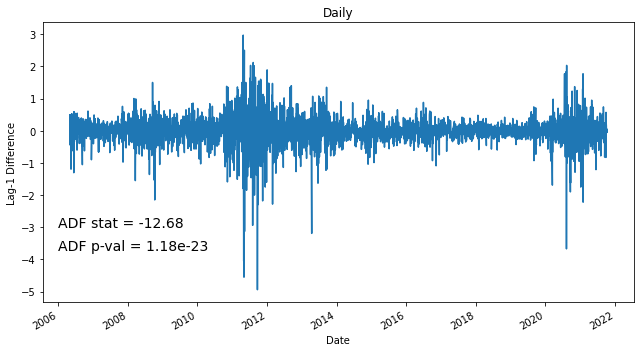

In [146]:
fig3, ax = plt.subplots(1,1,figsize=(9,5))
slv_dif1 = slv.diff().dropna()
adf_result = adfuller(slv_dif1['Close'])
slv_dif1['Close'].plot(figsize=(9,5))
ax.text(datetime.date(2006,1,1),-3,f'ADF stat = {adf_result[0]:.2f}',fontsize=14)
ax.text(datetime.date(2006,1,1),-3.7,f'ADF p-val = {adf_result[1]:.2e}',fontsize=14)
ax.set_ylabel('Lag-1 Difference')
ax.set_title('Daily')
fig3.tight_layout()
fig3.savefig('plots/fig3.png')

**KPSS results can't reject null hypothesis of trend-stationarity, confirming ADF result.**

In [149]:
kpss_result = kpss(slv_dif1['Close'],nlags='auto',regression='ct')
print(f'Kwiatkowski-Phillips-Schmidt-Shin test results: {kpss_result[0],kpss_result[1]}')

Kwiatkowski-Phillips-Schmidt-Shin test results: (0.0586318646525855, 0.1)


/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


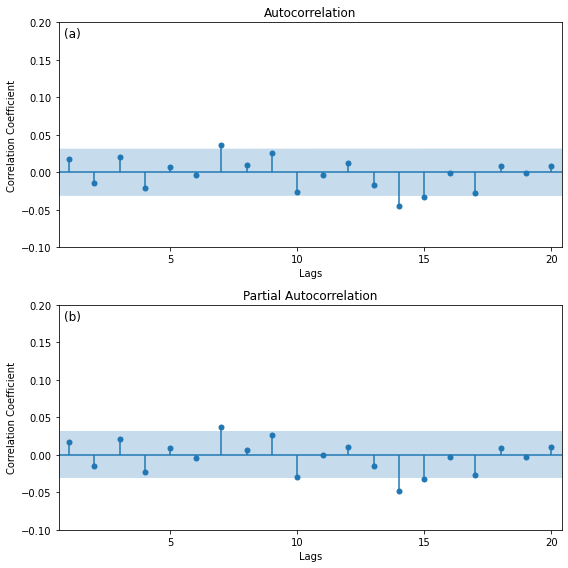

In [150]:
data = slv_dif1['Close'].dropna()
fig4, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))
plot_acf(data,alpha=0.05,lags=20,ax=ax1)
ax1.set_ylim(-0.1,0.2)
ax1.set_xlim(0.6,20.4)
ax1.set_xticks([5,10,15,20])
ax1.text(0.8,0.18,'(a)',fontsize=12)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Correlation Coefficient')
plot_pacf(data,alpha=0.05,lags=20,ax=ax2)
ax2.set_ylim(-0.1,0.2)
ax2.set_xlim(0.6,20.4)
ax2.set_xticks([5,10,15,20])
ax2.text(0.8,0.18,'(b)',fontsize=12)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Correlation Coefficient')
fig4.tight_layout()
fig4.savefig('plots/fig4.png')

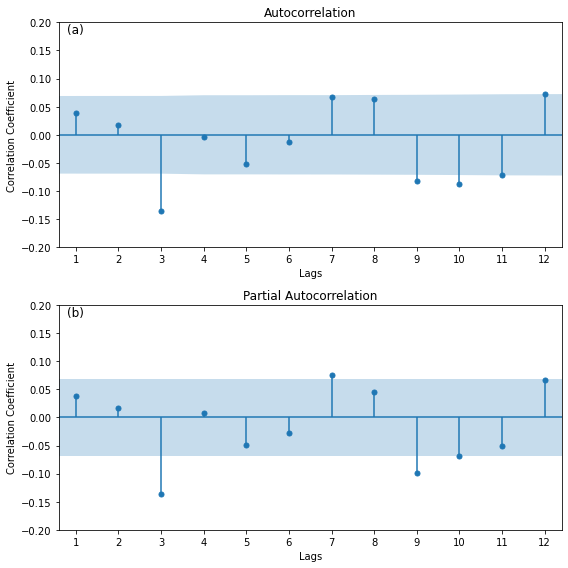

In [129]:
lags = 12
data = slv['Close'].resample('W').last().diff().dropna()
fig5, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))
plot_acf(data,alpha=0.05,lags=lags,ax=ax1)
ax1.set_ylim(-0.2,0.2)
ax1.set_xlim(0.6,lags+0.4)
ax1.set_xticks(np.arange(1,lags+1))
ax1.text(0.8,0.18,'(a)',fontsize=12)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Correlation Coefficient')
plot_pacf(data,alpha=0.05,lags=lags,ax=ax2)
ax2.set_ylim(-0.2,0.2)
ax2.set_xlim(0.6,lags+0.4)
ax2.set_xticks(np.arange(1,lags+1))
ax2.text(0.8,0.18,'(b)',fontsize=12)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Correlation Coefficient')
fig5.tight_layout()
fig5.savefig('plots/fig5.png')

In [122]:
data = slv['Close'].diff().dropna()
train = data.iloc[0:round(0.8*len(data))]
metrics = []
d = 0
for p in range(8):
    for q in range(8):
        try:
            model = ARIMA(train,order=(p,d,q),trend='n')
            result = model.fit()
            metrics.append((p,d,q,result.aic,result.bic))
        except:
            pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_resid.sort_values('AIC').head()

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, 

,p,d,q,AIC,BIC
60,7,0,4,3715.365763,3787.878157
63,7,0,7,3718.992960,3809.633452
29,3,0,5,3720.080287,3774.464583
44,5,0,4,3720.948211,3781.375206
30,3,0,6,3720.996165,3781.423160


In [125]:
d = 0
for p in range(8,13):
    for q in range(8,13):
        try:
            model = ARIMA(train,order=(p,d,q),trend='n')
            result = model.fit()
            metrics.append((p,d,q,result.aic,result.bic))
        except:
            pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_resid.sort_values('AIC').head()

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autor

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, 

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, 

,p,d,q,AIC,BIC
127,4,0,11,3713.274212,3809.957404
137,6,0,11,3714.489316,3823.257907
60,7,0,4,3715.365763,3787.878157
74,9,0,2,3715.932573,3788.444967
83,10,0,3,3716.013718,3800.611511


In [126]:
metr_resid.sort_values('BIC').head()

,p,d,q,AIC,BIC
0,0,0,0,3732.764660,3738.807360
9,1,0,1,3721.788922,3739.917021
1,0,0,1,3731.652082,3743.737481
8,1,0,0,3731.823615,3743.909014
17,2,0,1,3723.778706,3747.949504


In [136]:
train

Date
2006-05-07    0.183
2006-05-14    0.469
2006-05-21   -1.864
2006-05-28    0.070
2006-06-04   -0.495
              ...  
2018-08-12   -0.090
2018-08-19   -0.490
2018-08-26    0.000
2018-09-02   -0.270
2018-09-09   -0.330
Freq: W-SUN, Name: Close, Length: 645, dtype: float64

In [155]:
ARIMA(train,order=(5,0,2),trend='n').fit().summary()

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  645
Model:                 ARIMA(5, 0, 2)   Log Likelihood                -913.492
Date:                Sun, 19 Dec 2021   AIC                           1842.984
Time:                        06:31:08   BIC                           1878.738
Sample:                    05-07-2006   HQIC                          1856.857
                         - 09-09-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2647      0.049      5.398      0.000       0.169       0.361
ar.L2         -0.8804      0.040    -21.772      0.000      -0.960      -0.801
ar.L3         -0.1103      0.048     -2.288      0.022      -0.205      -0.016
ar.L4          0.0771      0.030      2.557      0.011       0.018       0.136
ar.L5         -0.2312      0.035     -6.655      0.000      -0.299      -0.163
ma.L1         -0.2117      0.038     -5.639      0.000      -0.285      -0.138
ma.L2          0.9109      0.035     25.899      0.000       0.842       0.980
sigma2         0.9935      0.025     39.301      0.000       0.944       1.043
===================================================================================
Ljung-Box (Q):                       60.20   Jarque-Bera (JB):             37854.24
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -3.16
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [135]:
data = slv['Close'].resample('W').last().diff().dropna()
train = data.iloc[0:round(0.8*len(data))]
metrics = []
d = 0
for p in range(6):
    for q in range(6):
        try:
            model = ARIMA(train,order=(p,d,q),trend='n')
            result = model.fit()
            metrics.append((p,d,q,result.aic,result.bic))
        except:
            pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_resid.sort_values('AIC').head()

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,p,d,q,AIC,BIC
32,5,0,2,1842.984056,1878.738059
28,4,0,4,1857.466942,1897.690195
17,2,0,5,1858.088660,1893.842663
29,4,0,5,1858.798898,1903.491401
35,5,0,5,1858.851365,1908.013119


In [154]:
split

NameError: name 'split' is not defined

In [128]:
metr_resid.sort_values('BIC').head()

,p,d,q,AIC,BIC
32,5,0,2,1842.984056,1878.738059
0,0,0,0,1877.127598,1881.596848
3,0,0,3,1863.960886,1881.837888
18,3,0,0,1865.960770,1883.837772
6,1,0,0,1877.369023,1886.307524


**15-day seasonality**

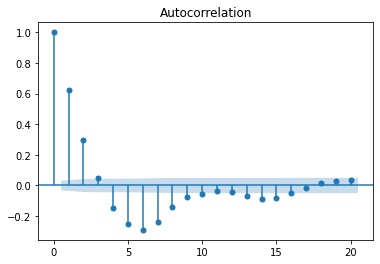

In [25]:
data = residual
plot_acf(data,alpha=0.05,lags=20)
plt.show()

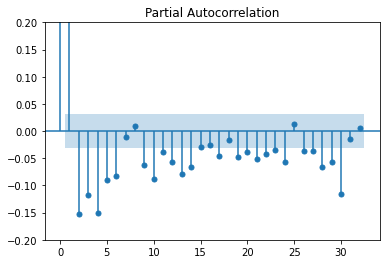

In [26]:
data = residual
plot_pacf(data,alpha=0.05,lags=32)
plt.ylim([-0.2,0.2])
plt.show()

**Resample to weekly data to reduce noise. Change period to 3 weeks (corresponding to 15 trading days).**

In [27]:
weekly=slv.resample('W').last()
weekly['pct_change'] = 100*weekly['Close'].pct_change()

Augmented Dickey-Fuller test results: (-20.559630164706263, 0.0)


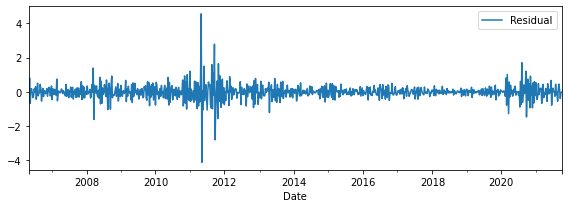

In [28]:
deco = sm.tsa.seasonal_decompose(weekly['Close'],model='additive',period=3)
wk3_trend = deco.trend
wk3_seasonal = deco.seasonal
wk3_residual = deco.resid
wk3_residual.dropna(inplace=True)
fig = plt.figure(figsize=(8,3))
wk3_residual.plot(label = 'Residual')
plt.legend(loc = 'best')
fig.tight_layout()
adf_result = adfuller(residual)
print(f'Augmented Dickey-Fuller test results: {adf_result[0],adf_result[1]}')

### Scenario 1: Removing trend/seasonality (Weekly)

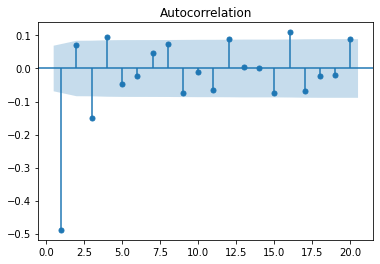

In [29]:
data = wk3_residual
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data,alpha=0.05,lags=np.arange(20)+1)
plt.show()

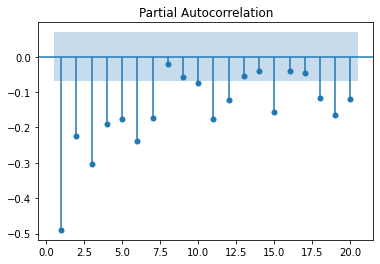

In [30]:
data = wk3_residual
plot_pacf(data,alpha=0.05,lags=np.arange(20)+1)
plt.show()

#### Summary ####
- **Significant negative correlations at lags 1 & 3 in ACF plot**
- **Lag 1 shows a larger negative correlation in the PACF plot, but other lags show significant correlations**
- **Thus, order classification is not clear through this method**


### Scenario 2: Differencing

**There is no significant correlation between the first-differenced value and the lags, until possibly
lag 14 or 15.**

In [79]:
weekly

Date
2006-04-30    13.812000
2006-05-07    13.995000
2006-05-14    14.464000
2006-05-21    12.600000
2006-05-28    12.670000
                ...    
2021-09-12    21.990000
2021-09-19    20.740000
2021-09-26    20.709999
2021-10-03    20.830000
2021-10-10    20.950001
Freq: W-SUN, Name: Close, Length: 807, dtype: float64

In [83]:
weekly = slv['Close'].resample('W').last()
wk_dif1 = weekly.diff().dropna()
#wk_dif2 = weekly.diff().diff().dropna()

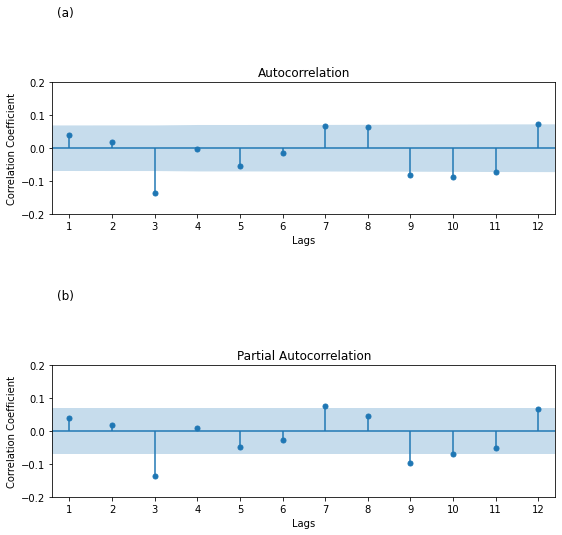

In [104]:
fig5, (ax1, ax2) = plt.subplots(2,1,figsize=(8,8))
data = wk_dif1
lags = 12
plot_acf(data,alpha=0.05,lags=lags,ax=ax1)
ax1.set_ylim(-0.2,0.2)
ax1.set_xlim(0.6,lags+0.4)
ax1.set_xticks(np.arange(1,lags+1))
ax1.text(0.7,0.4,'(a)',fontsize=12)
ax1.set_xlabel('Lags')
ax1.set_ylabel('Correlation Coefficient')
plot_pacf(data,alpha=0.05,lags=12,ax=ax2)
ax2.set_ylim(-0.2,0.2)
ax2.set_xlim(0.6,lags+0.4)
ax2.set_xticks(np.arange(1,lags+1))
ax2.text(0.7,0.4,'(b)',fontsize=12)
ax2.set_xlabel('Lags')
ax2.set_ylabel('Correlation Coefficient')
fig5.tight_layout()
fig5.savefig('plots/fig5.png')

Augmented Dickey-Fuller test results: (-12.681608785407201, 1.1836447522822532e-23)


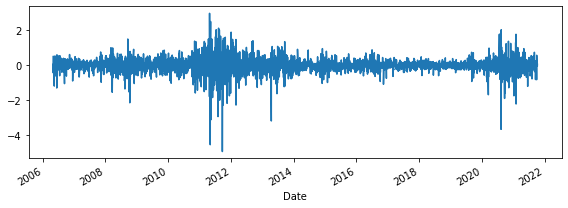

In [32]:
fig = plt.figure(figsize=(8,3))
data = slv.diff().dropna()['Close']
adf_result = adfuller(data)
print(f'Augmented Dickey-Fuller test results: {adf_result[0],adf_result[1]}')
data.plot()
fig.tight_layout()

In [35]:
from statsmodels.tsa.arima.model import ARIMA

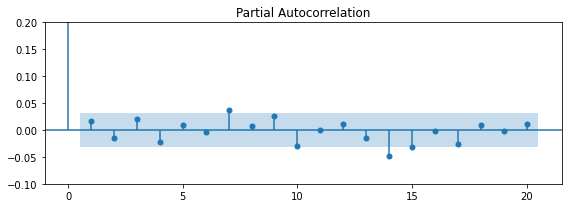

In [33]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
data = slv.diff().dropna()['Close']
plot_pacf(data,alpha=0.05,lags=20, ax=ax)
ax.set_ylim(-0.1,0.2)
fig.tight_layout()

In [97]:
data = wk_dif1
train = data.iloc[0:round(0.8*len(data))]
metrics = []
d = 0
for p in range(8):
    for q in range(8):
        try:
            model = ARIMA(train,order=(p,d,q),trend='n')
            result = model.fit()
            metrics.append((p,d,q,result.aic,result.bic))
        except:
            pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_resid.sort_values('AIC').head()

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,p,d,q,AIC,BIC
42,5,0,2,1842.984056,1878.738059
50,6,0,2,1844.683292,1884.906545
58,7,0,2,1845.792653,1890.485156
51,6,0,3,1846.903419,1891.595922
22,2,0,6,1846.999578,1887.222831


In [98]:
metr_resid.sort_values('BIC').head()

,p,d,q,AIC,BIC
42,5,0,2,1842.984056,1878.738059
0,0,0,0,1877.127598,1881.596848
3,0,0,3,1863.960886,1881.837888
24,3,0,0,1865.960770,1883.837772
50,6,0,2,1844.683292,1884.906545


In [100]:
data = slv['Close'].resample('W').last().diff().diff().dropna()
train = data.iloc[0:round(0.8*len(data))]
metrics = []
d = 0
for p in range(10):
    for q in range(10):
        try:
            model = ARIMA(train,order=(p,d,q),trend='n')
            result = model.fit()
            metrics.append((p,d,q,result.aic,result.bic))
        except:
            pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_resid.sort_values('AIC').head()

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


,p,d,q,AIC,BIC
69,6,0,9,1849.616339,1921.099519
49,4,0,9,1851.037442,1913.585224
75,7,0,5,1852.844256,1910.924339
78,7,0,8,1853.385962,1924.869141
85,8,0,5,1853.442990,1915.990772


In [ ]:
train = data.iloc[0:round(0.8*len(data))]
metrics = []
d = 0
for d in range(2):
    for p in range(5):
        for q in range(5):
            try:
                model = ARIMA(train,order=(p,d,q),trend='n')
                result = model.fit()
                metrics.append((p,d,q,result.aic,result.bic))
            except:
                pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_resid.sort_values('AIC').head()

In [ ]:
train = data.iloc[0:round(0.8*len(data))]
metrics = []
d = 0
for p in range(6,9):
    for q in range(13,17):
        try:
            model = ARIMA(train,order=(p,d,q),trend='n')
            result = model.fit()
            metrics.append((p,d,q,result.aic,result.bic))
        except:
            pass
metr_resid = pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC'])
metr_resid.sort_values('AIC').head()

In [41]:
metrics = []
p, d, q = 14, 0, 14
model = ARIMA(train,order=(p,d,q),trend='n')
result = model.fit()
metrics.append((p,d,q,result.aic,result.bic))
p, d, q = 7, 0, 8
model = ARIMA(train,order=(p,d,q),trend='n')
result = model.fit()
metrics.append((p,d,q,result.aic,result.bic))
p, d, q = 1, 0, 1
model = ARIMA(train,order=(p,d,q),trend='n')
result = model.fit()
metrics.append((p,d,q,result.aic,result.bic))
print(pd.DataFrame(metrics,columns=['p','d','q','AIC','BIC']))

/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/ewilson/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autor

    p  d   q          AIC          BIC
0  14  0  14  3715.778587  3891.007549
1   7  0   8  3717.174314  3813.852362
2   1  0   1  3721.588416  3739.715550


**We try the weekly sample.**

Augmented Dickey-Fuller test results: (-5.809963797510067, 4.42501163569115e-07)


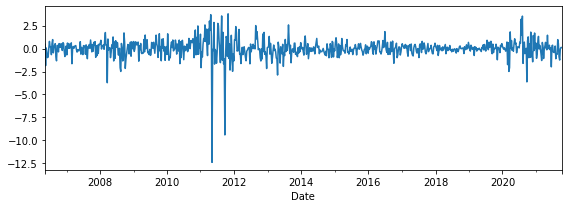

In [30]:
fig = plt.figure(figsize=(8,3))
wk_dif1 = weekly.diff().dropna()
adf_result = adfuller(wk_dif1['Close'])
print(f'Augmented Dickey-Fuller test results: {adf_result[0],adf_result[1]}')
wk_dif1.Close.plot()
fig.tight_layout()

In [59]:
weekly

,Day,Open,Low,High,Close,Volume,pct_change
Date,,,,,,,
2006-04-30,1,12.900000,12.870000,13.980000,13.812000,23432000,NaN
2006-05-07,6,14.000000,13.750000,14.030000,13.995000,6586000,1.324935
2006-05-14,11,14.890000,14.217000,14.900000,14.464000,10129000,3.351197
2006-05-21,16,12.291000,12.168000,12.683000,12.600000,8460000,-12.887168
2006-05-28,21,12.769000,12.490000,12.777000,12.670000,3477000,0.555556
...,...,...,...,...,...,...,...
2021-09-12,3870,22.309999,21.990000,22.379999,21.990000,17921300,-3.889856
2021-09-19,3875,20.990000,20.680000,21.010000,20.740000,44713900,-5.684402
2021-09-26,3880,20.510000,20.480000,20.830000,20.709999,23093600,-0.144653


**Small but significant correlation at lag 3 for both ACF & PACF.**

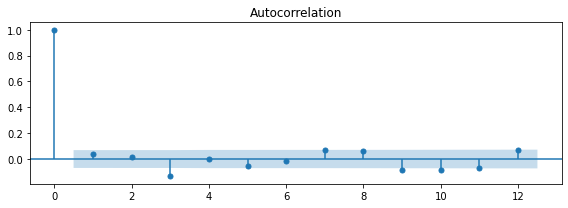

In [382]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
data = wk_dif1['Close']
plot_acf(data,alpha=0.05,lags=12, ax=ax)
fig.tight_layout()

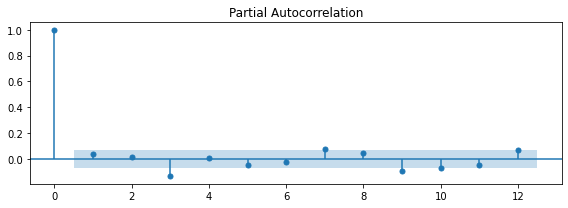

In [383]:
fig, ax = plt.subplots(1,1,figsize=(8,3))
data = wk_dif1['Close']
plot_pacf(data,alpha=0.05,lags=12, ax=ax)
fig.tight_layout()

#### Summary ####
- **Significant correlation at lag 3 in both ACF and PACF plots**
- **PACF plot showing similar pattern as ACF plot**
- **Again, a model classification from the plot is not obvious**